# Условие

Обучить бинарный классификатор на основе сверточных нейронных сетей для датасета.
- Вы вольны выбирать любое количество слоёв, подбирать гиперпараметры, выбирать оптимизатор, функцию ошибки итд.    
- Можете разбивать на train-val-test исходя из того, как думаете, что будет лучше.

4 балла:
- Модель должна работоспособна, воспроизводима, код должен быть читаемым;
- Метрика качества accuracy должна быть не ниже 0.9;
- Процесс схождения должен быть залогирован (хотя бы просто графиками в matplotlib, но желательно втч. и в Tensorboard/ClearML/...).

5 баллов:
- Всё то же самое, что на 4 балла, но выполнены подзадания 1, 2 и 3, а метрика качества accuracy должна быть не ниже 0.95.



Подзадания:
- [X] Выведите кол-во обучаемых параметров сети;    
- [X] Напишите несколько предложений выводов - что помогло в решении и повысило качество, что нет.
- [X] Посчитайте F1-score на тестовой подвыборке.

По желанию к выполнению, в разбалловке не учитывается:     
- [ ] Выведите confusion matrix для тестовой подвыборки;    

# Особенности

У меня все выполнялось на cpu, разрешили взять половину

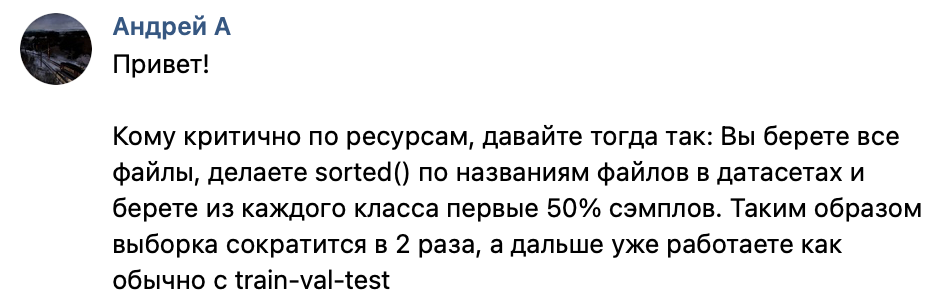


# Домашняя работа

## Подключаем билиотеки и константы

In [1]:
!pip install -r requirements.txt

In [2]:
import os
import time
import torch
import pickle
import warnings
import progressbar
import torchvision
import multiprocessing

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch import no_grad, max, device, cuda
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchmetrics.classification import BinaryF1Score

from source.cnn import CNN
from source.model import Model
from source.constant import *

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
DEVICE = device("cuda:0" if cuda.is_available() else "cpu")
torch.set_num_threads(int(0.9 * multiprocessing.cpu_count()))
print(f'Устройство: {DEVICE}, колличество ядер процессора: {torch.get_num_threads()}')

Устройство: cuda:0, колличество ядер процессора: 28


## Подгрузка данных

In [4]:
SHAPE = 256
data_dir = './indoor_outdoor_dataset/'

transform = transforms.Compose([
    transforms.AugMix(),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.Resize([SHAPE, SHAPE]),
    transforms.ToTensor(),           
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

full_data = ImageFolder(data_dir, transform=transform)

train_size = int(0.9 * len(full_data))
test_size = len(full_data) - train_size
print(f'train_size = {train_size}\ntest_size = {test_size}')

train_data, test_data = random_split(full_data, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

train_size = 369471
test_size = 41053


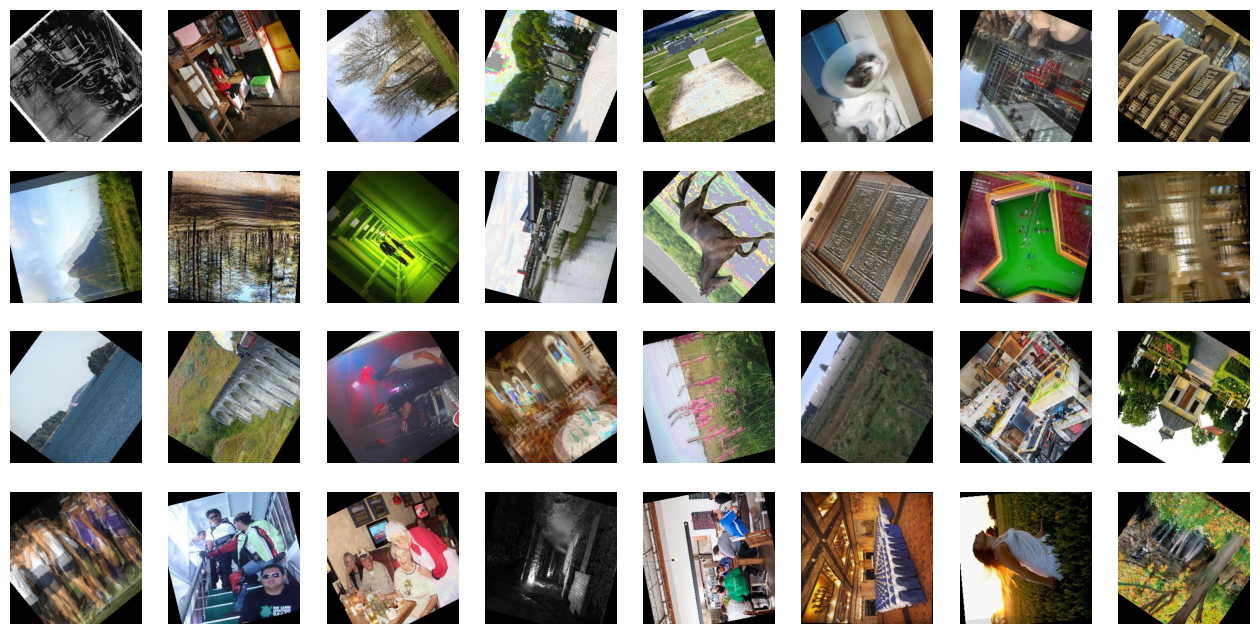

In [5]:
_image, cols = [], 4
buffer_images, _ = next(iter(train_loader))
_image = [ make_grid(buffer_image, normalize=True).permute(1, 2, 0).numpy() \
          for buffer_image in buffer_images]
plt.figure(figsize=(16, 8))
rows = int(len(_image)/cols)
for i, image in enumerate(_image, 1):
    plt.subplot(cols, rows, i)
    plt.imshow(image)
    plt.axis("off")
plt.show()

**Что-то сильный шум на вид, возможно надо будет перегнать**

## Функция для отображения результатов на выборках

In [6]:
def dataTest(model, df):
    test_loss, test_acc, test_f1 = [], [], []
    model.model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(df):
            inputs = inputs.to(DEVICE)
            labels = labels.float().to(DEVICE)

            outputs = model.model(inputs).view(-1)
            loss = model.criterion(outputs, labels)

            test_loss.append(loss.item())
            test_acc.append(model._accuracy(outputs, labels))
            test_f1.append(model._f1(outputs.cpu(), labels.cpu()))

    print(
        f'Loss: {np.mean(test_loss)}',
        f'Accuracy: {np.mean(test_acc)}',
        f'F1: {np.mean(test_f1)}'
    )

In [7]:
def load_lists_from_file(file_name):
    with open(file_name, 'rb') as f:
        list1, list2, list3, list4, list5, list6 = pickle.load(f)
    return list1, list2, list3, list4, list5, list6, len(list6)

## Обучение и эксплуатация

Как было написано в начале, комментарии и выводе. В момент заполнения данного ноутбука у меня уже появилась видеокарта и я мог на ней проводить вычисления. В процессе перевычисления задачи я столкнулся с проблемой, что ноутбуки зависали и результат не сохранялся. Я начал думать как это решить и не нашел ничего лучше как в ноутбуке подготовить решение и перенести его в py файл и запустить из терминал после через tmux спойкойно оставить сессию, а результат вычисления сохранить в файл `mymodel` и спокойно загрузить его в блоках ниже. Весь код можно посмотреть в исходниках в прикрепленной директории, если ее нет то я в течении минут готов сбросить ссылку на гитхаб, мои контакты [VK](https://vk.com/stepanphilimonv)

In [8]:
cnn = CNN().to(DEVICE)
cnn.load_state_dict(torch.load('mymodel'))
criterion = nn.BCELoss()
optimizer = optim.SGD(cnn.parameters(), lr=LEARNING_RATE)
model = Model(cnn, criterion, optimizer, DEVICE)
print(f'{cnn}\nКол-во обучаемых параметров сети: {sum([p.numel() for p in cnn.parameters()])}')

CNN(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=65536, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=1, bias=True)
    (16): Sigmoid()
  )
)
Кол-во обучаемых параметров сети: 33943873


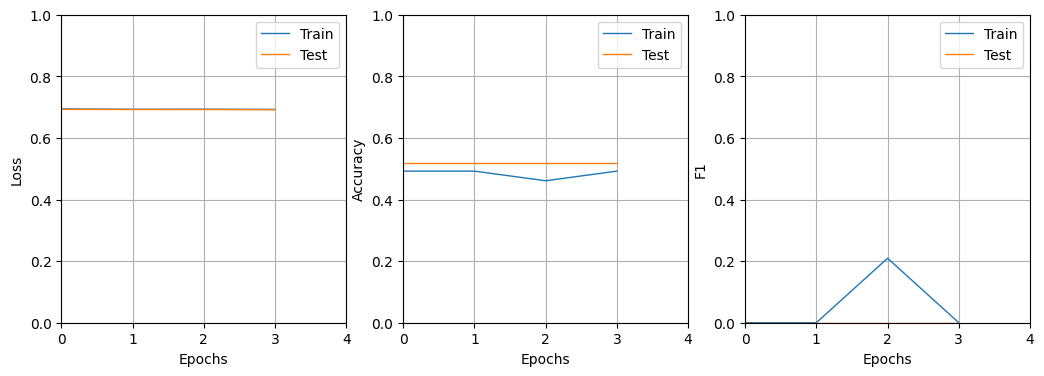

In [9]:
tr_loss, val_loss, tr_acc, val_acc, tr_f1, val_f1, size = load_lists_from_file('work.log')
model.plotLAF(tr_loss, val_loss, tr_acc, val_acc, tr_f1, val_f1, size)

In [11]:
dataTest(model, train_loader)

  0%|▎                                                                                                                             | 26/11546 [00:05<39:11,  4.90it/s]


KeyboardInterrupt: 

In [ ]:
dataTest(model, test_loader)

**Вывод:**

#### До старый, до появления gpu

1) Оно же ключевое, Apple M1 не подходит для обучение нейро-сетей, даже если брать в расчет, что у меня не очень удачно подобраны слои/гиперпараметры/функция ошибки и т. д. - Я уверен, что если это все подобрать сильно быстрее работать не будет.

Теперь по существу:

2) Так как бинарная классификация, то изначально ошибка/accuracy были в районе 0.5, например, на данных c MNIST ошибка/accuracy в районе 1.0/0.1. И конкретно в данном случае метрика F1 явлется более информативной, т.к. на тестовых данных при 1-ой эпохе она показала **0**. В дальнейшем accuracy и F1 показывали +- одинаковый результат, что видно на графике.
3) Из за технического ограничения не было возможности взять и четверть датасета(вычисления были бы ~24 часа). Из за этого набор данных крайне ограничен и возникает на тестовой выборке недо обучение, то есть, в какой-то момент просто был выход на "плато" и максимальное значение accuracy на тестовой выборке было 0.868. Если расширить набор данных для обучения, проблем с достижением 0.951 не было бы, но из за техничего ограничения не было возможности.

Дополнительные наблюдения:

4) Интересный результат был достигнут, когда картинки сохранялись в GRAY цвете, и объем в памяти уменьшался и проще архитектуру сети можно было использовать и сам процесс обучения был быстрее на порядок. Из бонусов и дальнейшее использование модели было бы проще для того, чтобы внедрить например в носимое устройство. Но недостаток, что теряется информация о цветах, в некоторых ситациях может быть критично. *Размер датасета тоже небольшой*.
5) При сжати через transforms.Resize() например до 64х64 теряется много информации, при 128х128 были не большие потери. Чтобы обучение прошло лучше оставил изначальный размер.

#### Новый после gpu
1) **todo**

2) C Adam проблемы, с ним вообще схождения не было